In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)

## Preprocessing

In [8]:
setwd("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/final_biom/")

biom <- import_biom("all_cohorts_cadaver_deblur.biom")
map <- import_qiime_sample_data("all_cadaver_metadata.txt")
tree <- read_tree("rep_phylo.tre")
cadaver_nt <- merge_phyloseq(biom,tree,map)
cadaver_nt <- prune_samples(sample_sums(cadaver_nt) > 1000, cadaver_nt)
cadaver <- merge_phyloseq(biom,tree,map) %>%
    prune_samples((sample_sums(.) > 1000), .) %>%
    filter_taxa(function(x) sum(x > 3) > (0.001*length(x)), TRUE) %>%
    transform_sample_counts(function(x) x / sum(x))

saveRDS(cadaver_nt, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver_nt.rds")
saveRDS(cadaver, "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver.rds")
                                                      

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”

In [3]:
cadaver_nt = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver_nt.rds")
cadaver = readRDS("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver.rds")


In [9]:
cadaver

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1990 taxa and 264 samples ]
sample_data() Sample Data:       [ 264 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 1990 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1990 tips and 1988 internal nodes ]

### Alpha Diversity Measures

##### Shannon Diversity Calculations

In [4]:
sample_tab = read.csv("/group/gilbert-lab/Lutz/Cadaver/All_cohorts/final_biom/all_cadaver_metadata.csv")
colnames(sample_tab)[1] <- "SampleID"

In [10]:
sha = estimate_richness(cadaver_nt, split = TRUE, measures = "Shannon")
sha$SampleID = rownames(sha)

dfsha = merge(sha, sample_tab, on="SampleID")

ordsha = sha %>% group_by("Organ") %>%
    summarize(med.sha = median(Shannon)) %>%
    arrange(desc(med.sha)) %>%
    magrittr::extract2("Organ")

stats.sha = dfsha %>%
    group_by(Organ) %>%
    summarize(median = median(Shannon), 
              mean = mean(Shannon),
              sd = sd(Shannon),
              sem = sd(Shannon/sqrt(length(Shannon)))) %>%
    arrange(-desc(mean))
stats.sha

Organ,median,mean,sd,sem
Heart,1.624730,1.429424,0.9792621,0.1548349
Blood,1.859476,1.530832,0.8126412,0.3071495
Spleen,1.834304,1.678410,1.0405528,0.1734255
Liver,1.621973,1.751835,1.2217730,0.1203849
Brain,1.989188,1.825932,0.7555543,0.1139041
Uterus,2.641988,2.700381,0.6858481,0.1902200
Prostate,3.054951,2.794671,1.0881414,0.2374519


In [22]:
#Record Stats
cat("Tests Output", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt")
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
cat("Shannon Div stats\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(stats.sha, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)

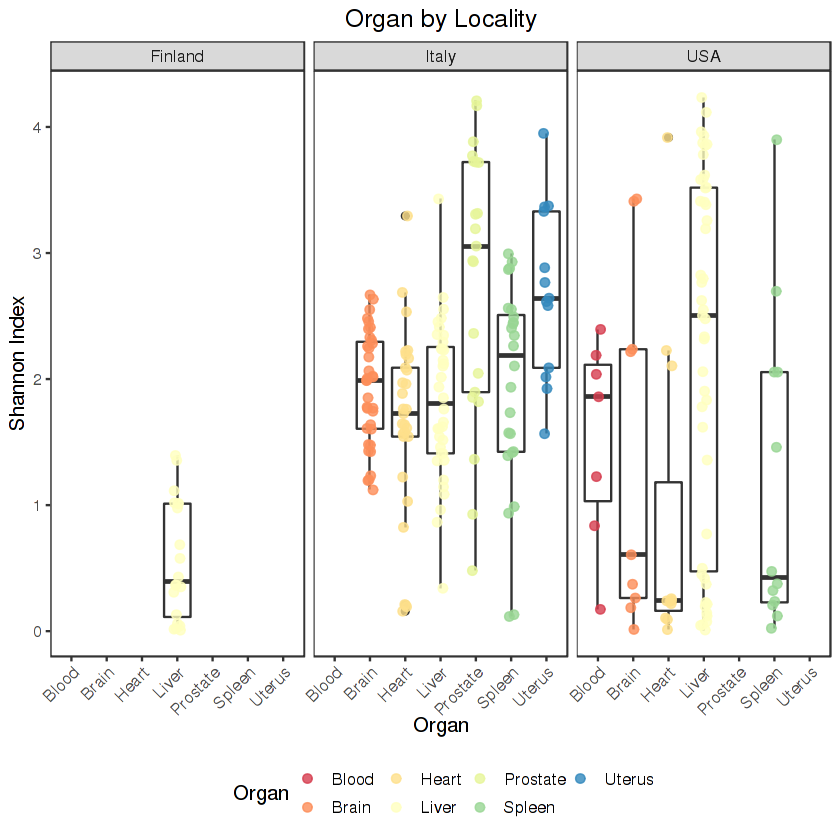

In [39]:
#dfsha$The.manner.of.death <- factor(dfsha$The.manner.of.death, levels=c("Accident", "Natural","Homicide", "Suicide"))

p = ggplot(dfsha, aes(x = Organ, y = Shannon)) + ggtitle("Organ by Locality")

p = p + geom_boxplot() + ylab("Shannon Index")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,1200))

p = p + geom_point(size = 2,alpha=.8, aes(color = Organ),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 45, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
                           

p = p + facet_wrap(~Location)

p

In [19]:
krusk = kruskal.test(Shannon ~ The_manner_of_death, data=dfsha) 
krusk


	Kruskal-Wallis rank sum test

data:  Shannon by The_manner_of_death
Kruskal-Wallis chi-squared = 59.814, df = 8, p-value = 5.07e-10


In [21]:
library(dunn.test)
dunn = dunn.test(dfsha$Shannon, g=dfsha$The_manner_of_death, method="BH")
dunn

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 59.8137, df = 8, p-value = 0


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Accident   Accident   Accident   Accident   Homicide    Natural
---------+------------------------------------------------------------------
Accident |  -0.219207
         |     0.4649
         |
Accident |  -2.706723  -1.365774
         |    0.0175*     0.1548
         |
Accident |  -1.613280  -1.144665  -0.162545
         |     0.1200     0.2065     0.4611
         |
Homicide |  -3.550184  -1.690376  -0.395019  -0.066482
         |    0.0012*     0.1259     0.4023     0.4870
         |
 Natural |   2.639950   1.421426   4.425936   2.598502   5.397581
         |    0.0166*     0.1470    0.0000*    0.0169*    0.0000*
         |
Natural  |  -2.551469  -0.853202   1.039203   0.726008   1.684446  -4.

$chi2
[1] 59.81369

$Z
 [1] -0.21920719 -2.70672321 -1.36577477 -1.61328065 -1.14466596 -0.16254532
 [7] -3.55018479 -1.69037620 -0.39501995 -0.06648298  2.63995050  1.42142661
[13]  4.42593621  2.59850212  5.39758181 -2.55146906 -0.85320285  1.03920306
[19]  0.72600810  1.68444676 -4.97440324 -3.76596096 -1.48696512  0.00805831
[25]  0.17752513  0.50186995 -5.93519235 -1.44342167 -1.99253632 -1.63877970
[31] -0.92236432 -0.69187269 -0.76391157 -2.70612925 -1.35543259 -0.95731467

$P
 [1] 4.132443e-01 3.397544e-03 8.600483e-02 5.334177e-02 1.261738e-01
 [6] 4.354382e-01 1.924804e-04 4.547800e-02 3.464141e-01 4.734967e-01
[11] 4.145907e-03 7.759639e-02 4.801245e-06 4.681573e-03 3.377254e-08
[16] 5.363492e-03 1.967734e-01 1.493552e-01 2.339169e-01 4.604768e-02
[21] 3.272447e-07 8.295486e-05 6.851201e-02 4.967852e-01 4.295480e-01
[26] 3.078795e-01 1.467506e-09 7.445086e-02 2.315612e-02 5.062957e-02
[31] 1.781693e-01 2.445086e-01 2.224600e-01 3.403627e-03 8.763989e-02
[36] 1.692042e-01

$P.adjusted
 [1] 4.648999e-01 1.747308e-02 1.548087e-01 1.200190e-01 2.064662e-01
 [6] 4.610522e-01 1.154883e-03 1.259391e-01 4.022873e-01 4.870251e-01
[11] 1.658363e-02 1.470247e-01 4.321120e-05 1.685366e-02 6.079057e-07
[16] 1.755325e-02 2.724555e-01 2.337733e-01 3.007503e-01 1.184083e-01
[21] 3.926937e-06 5.972750e-04 1.450843e-01 4.967852e-01 4.685978e-01
[26] 3.694554e-01 5.283022e-08 1.489017e-01 6.946837e-02 1.215110e-01
[31] 2.565638e-01 3.035280e-01 2.966133e-01 1.531632e-02 1.502398e-01
[36] 2.538063e-01

$comparisons
 [1] "Accident - Accident_road traffic accident"                      
 [2] "Accident - Accident_Road traffic accident"                      
 [3] "Accident_road traffic accident - Accident_Road traffic accident"
 [4] "Accident - Accident_Work related accident"                      
 [5] "Accident_road traffic accident - Accident_Work related accident"
 [6] "Accident_Road traffic accident - Accident_Work related accident"
 [7] "Accident - Homicide"                                            
 [8] "Accident_road traffic accident - Homicide"                      
 [9] "Accident_Road traffic accident - Homicide"                      
[10] "Accident_Work related accident - Homicide"                      
[11] "Accident - Natural"                                             
[12] "Accident_road traffic accident - Natural"                       
[13] "Accident_Road traffic accident - Natural"                       
[14] "Accident_Work related accident - Natural"                       
[15] "Homicide - Natural"                                             
[16] "Accident - Natural death"                                       
[17] "Accident_road traffic accident - Natural death"                 
[18] "Accident_Road traffic accident - Natural death"                 
[19] "Accident_Work related accident - Natural death"                 
[20] "Homicide - Natural death"                                       
[21] "Natural - Natural death"                                        
[22] "Accident - Suicide"                                             
[23] "Accident_road traffic accident - Suicide"                       
[24] "Accident_Road traffic accident - Suicide"                       
[25] "Accident_Work related accident - Suicide"                       
[26] "Homicide - Suicide"                                             
[27] "Natural - Suicide"                                              
[28] "Natural death - Suicide"                                        
[29] "Accident - Undetermined"                                        
[30] "Accident_road traffic accident - Undetermined"                  
[31] "Accident_Road traffic accident - Undetermined"                  
[32] "Accident_Work related accident - Undetermined"                  
[33] "Homicide - Undetermined"                                        
[34] "Natural - Undetermined"                                         
[35] "Natural death - Undetermined"                   

In [23]:
#Record Stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# export kruskal-wallis
cat("Shannon Div Krsukal-Wallis\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(krusk, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# add 2 newlines
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# export dunn.test
cat("Shannon Div Dunn Test\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(dunn, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)

### Observed Diversity Calculations

In [24]:
obs = estimate_richness(cadaver_nt, split = TRUE, measures = "Observed")
obs$SampleID = rownames(obs)

In [26]:
#Export to local to remove "X"'s in front of SampleID, reimport and continue - try setting as.factor next time
#write.csv(obs, "/group/gilbert-lab/Lutz/Cadaver/temp_obs.csv")
obs = read.csv("/group/gilbert-lab/Lutz/Cadaver/temp_obs.csv")

In [29]:
dfobs = merge(obs, sample_tab, on="SampleID")

ordobs = obs %>% group_by("The_manner_of_death") %>%
    summarize(med.obs = median(Observed)) %>%
    arrange(desc(med.obs)) %>%
    magrittr::extract2("The_manner_of_death")

stats.obs = dfobs %>%
    group_by(The_manner_of_death) %>%
    summarize(median = median(Observed), 
              mean = mean(Observed),
              sd = sd(Observed),
              sem = sd(Observed/sqrt(length(Observed)))) %>%
    arrange(-desc(mean))
stats.obs

The_manner_of_death,median,mean,sd,sem
Accident_Work related accident,32.5,46.00000,33.21646,16.608231
Accident_road traffic accident,38.5,47.66667,32.27796,13.177422
Natural,34.0,52.72093,48.53292,7.401201
Accident_Road traffic accident,48.0,55.11765,35.78212,8.678439
Accident,33.0,55.57377,52.87106,6.769445
Natural death,43.0,55.96825,36.28292,4.571219
Suicide,45.0,71.08889,53.05436,7.908876
Homicide,54.0,86.91304,62.67515,13.068671
Undetermined,247.0,247.00000,144.24978,102.000000


In [30]:
#Record Stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
cat("Obs Richness stats\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(stats.obs, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)


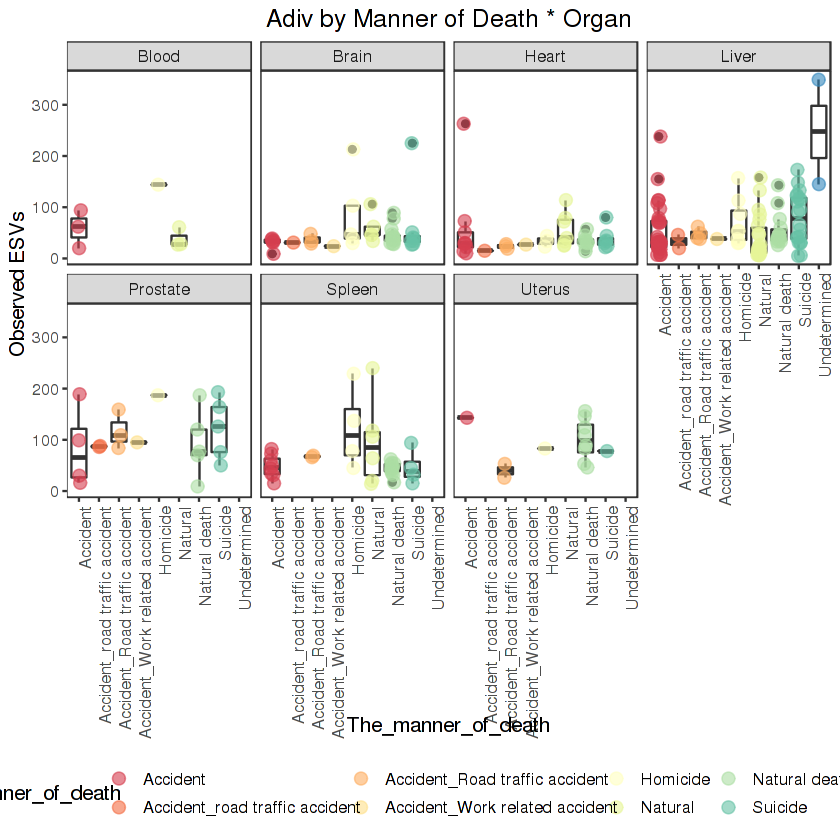

In [41]:
#dfobs$The_manner_of_death <- factor(dfobs$The_manner_of_death, levels=c("Accident", "Natural","Homicide", "Suicide"))

p = ggplot(dfobs, aes(x = The_manner_of_death, y = Observed)) + ggtitle("Adiv by Manner of Death * Organ")

p = p + geom_boxplot() + ylab("Observed ESVs")  #+ coord_flip(ylim = c(0,200))

#p = p + coord_cartesian(ylim = c(0, 2000))

#p = p + scale_y_continuous(limits = c(0,1200))

p = p + geom_point(size = 3,alpha=.6, aes(color = The_manner_of_death),
                   position = position_jitter(h = 0, w = 0.1)) +
                  scale_colour_brewer(palette="Spectral")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family="Times New Roman"),
                           legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p = p + facet_wrap(~Organ, ncol=4)

p

In [42]:
krusk = kruskal.test(Observed ~ The_manner_of_death, data=dfobs) 
krusk


	Kruskal-Wallis rank sum test

data:  Observed by The_manner_of_death
Kruskal-Wallis chi-squared = 19.782, df = 8, p-value = 0.01119


In [45]:
library(dunn.test)
dunn = dunn.test(dfobs$Observed, g=dfobs$The_manner_of_death, method="BH")
dunn

  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 19.7822, df = 8, p-value = 0.01


                           Comparison of x by group                            
                             (Benjamini-Hochberg)                              
Col Mean-|
Row Mean |   Accident   Accident   Accident   Accident   Homicide    Natural
---------+------------------------------------------------------------------
Accident |   0.008824
         |     0.4965
         |
Accident |  -0.855505  -0.502053
         |     0.3070     0.3821
         |
Accident |   0.217741   0.168254   0.624438
         |     0.4655     0.4726     0.3422
         |
Homicide |  -2.894853  -1.553411  -1.481035  -1.514973
         |     0.0341     0.1444     0.1386     0.1460
         |
 Natural |   0.228415   0.095701   0.977717  -0.127981   2.918038
         |     0.4916     0.4751     0.2685     0.4755     0.0634
         |
Natural  |  -1.651788  -0.703303  -0.227143  -0.793384   1.689607  

$chi2
[1] 19.7822

$Z
 [1]  0.008824573 -0.855505930 -0.502053664  0.217741176  0.168254484
 [6]  0.624438043 -2.894853039 -1.553411992 -1.481035891 -1.514973510
[11]  0.228415935  0.095701527  0.977717334 -0.127981679  2.918038912
[16] -1.651788372 -0.703303817 -0.227143899 -0.793384740  1.689607710
[21] -1.729896647 -2.219307708 -1.012138128 -0.707745043 -1.051265045
[26]  1.062025563 -2.258300623 -0.714236562 -2.529897406 -2.231207246
[31] -2.118091680 -2.229011853 -1.505222415 -2.576129451 -2.118069913
[36] -1.912246950

$P
 [1] 0.496479550 0.196135561 0.307814886 0.413815390 0.433191540 0.266169974
 [7] 0.001896680 0.060162370 0.069298505 0.064889556 0.409661451 0.461878814
[13] 0.164107073 0.449081736 0.001761202 0.049288850 0.240933216 0.410155925
[19] 0.213776849 0.045551515 0.041824371 0.013232899 0.155736007 0.239551800
[25] 0.146568438 0.144112040 0.011963462 0.237540456 0.005704794 0.012833702
[31] 0.017083652 0.012906558 0.066133452 0.004995662 0.017084574 0.027922263

$P.adjusted
 [1] 0.49647955 0.30699479 0.38211503 0.46554231 0.47257259 0.34221854
 [7] 0.03414025 0.14438969 0.13859701 0.14600150 0.49159374 0.47507535
[13] 0.26853885 0.47549831 0.06340327 0.12674276 0.32124429 0.47631011
[19] 0.32066527 0.12614266 0.12547311 0.05954804 0.26697601 0.33168711
[25] 0.26382319 0.27305439 0.08613692 0.34205826 0.05134315 0.07700221
[31] 0.06833461 0.06637658 0.14004731 0.05994794 0.06150446 0.09138195

$comparisons
 [1] "Accident - Accident_road traffic accident"                      
 [2] "Accident - Accident_Road traffic accident"                      
 [3] "Accident_road traffic accident - Accident_Road traffic accident"
 [4] "Accident - Accident_Work related accident"                      
 [5] "Accident_road traffic accident - Accident_Work related accident"
 [6] "Accident_Road traffic accident - Accident_Work related accident"
 [7] "Accident - Homicide"                                            
 [8] "Accident_road traffic accident - Homicide"                      
 [9] "Accident_Road traffic accident - Homicide"                      
[10] "Accident_Work related accident - Homicide"                      
[11] "Accident - Natural"                                             
[12] "Accident_road traffic accident - Natural"                       
[13] "Accident_Road traffic accident - Natural"                       
[14] "Accident_Work related accident - Natural"                       
[15] "Homicide - Natural"                                             
[16] "Accident - Natural death"                                       
[17] "Accident_road traffic accident - Natural death"                 
[18] "Accident_Road traffic accident - Natural death"                 
[19] "Accident_Work related accident - Natural death"                 
[20] "Homicide - Natural death"                                       
[21] "Natural - Natural death"                                        
[22] "Accident - Suicide"                                             
[23] "Accident_road traffic accident - Suicide"                       
[24] "Accident_Road traffic accident - Suicide"                       
[25] "Accident_Work related accident - Suicide"                       
[26] "Homicide - Suicide"                                             
[27] "Natural - Suicide"                                              
[28] "Natural death - Suicide"                                        
[29] "Accident - Undetermined"                                        
[30] "Accident_road traffic accident - Undetermined"                  
[31] "Accident_Road traffic accident - Undetermined"                  
[32] "Accident_Work related accident - Undetermined"                  
[33] "Homicide - Undetermined"                                        
[34] "Natural - Undetermined"                                         
[35] "Natural death - Undetermined"                                   
[36] "Suicide - Undetermined"

In [46]:
#Record Stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# export kruskal-wallis
cat("Observed Richness Krsukal-Wallis\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(krusk, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# add 2 newlines
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
# export dunn.test
cat("Observed Richness Dunn Test\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(dunn, file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)

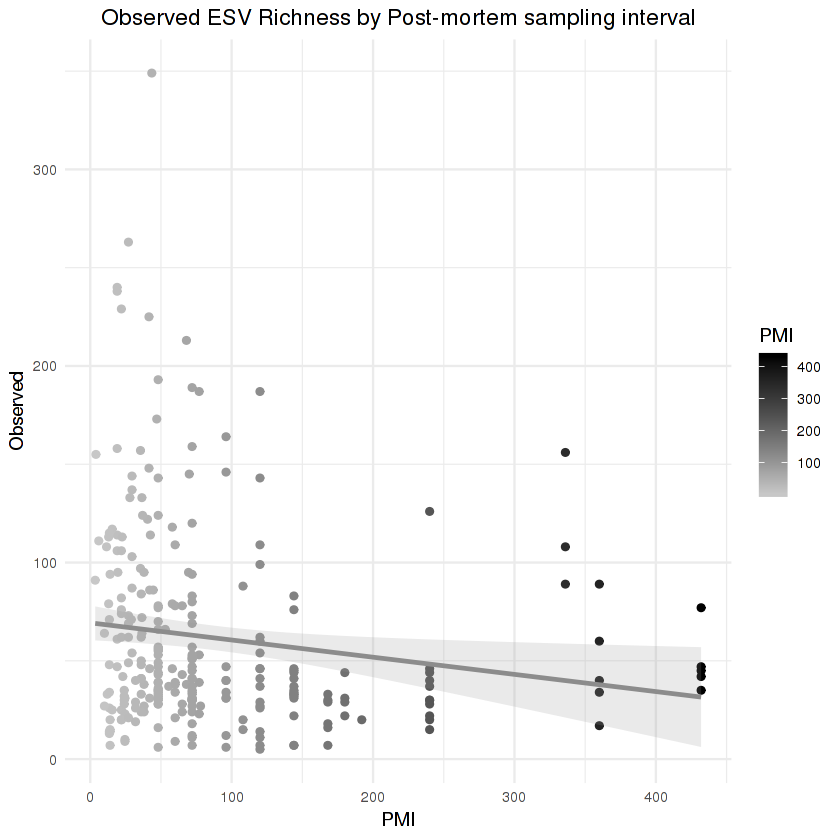

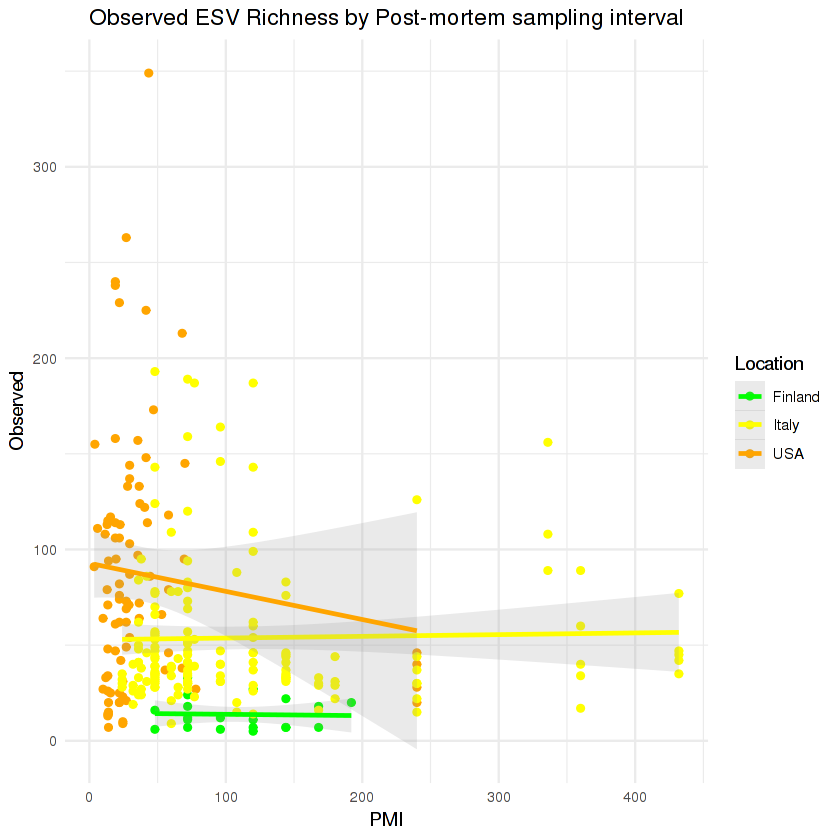

In [48]:
p1 = ggplot(dfobs, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval")
p1 = p1 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p1 = p1 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p1 = p1 + scale_colour_gradient(low = "grey78", high = "black")
p1

p2 = ggplot(dfobs, aes(x=PMI, y=Observed, colour = Location)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval")
p2 = p2 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p2 = p2 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p2 = p2 + scale_colour_manual(values = c("Green", "Yellow", "Orange"))
p2

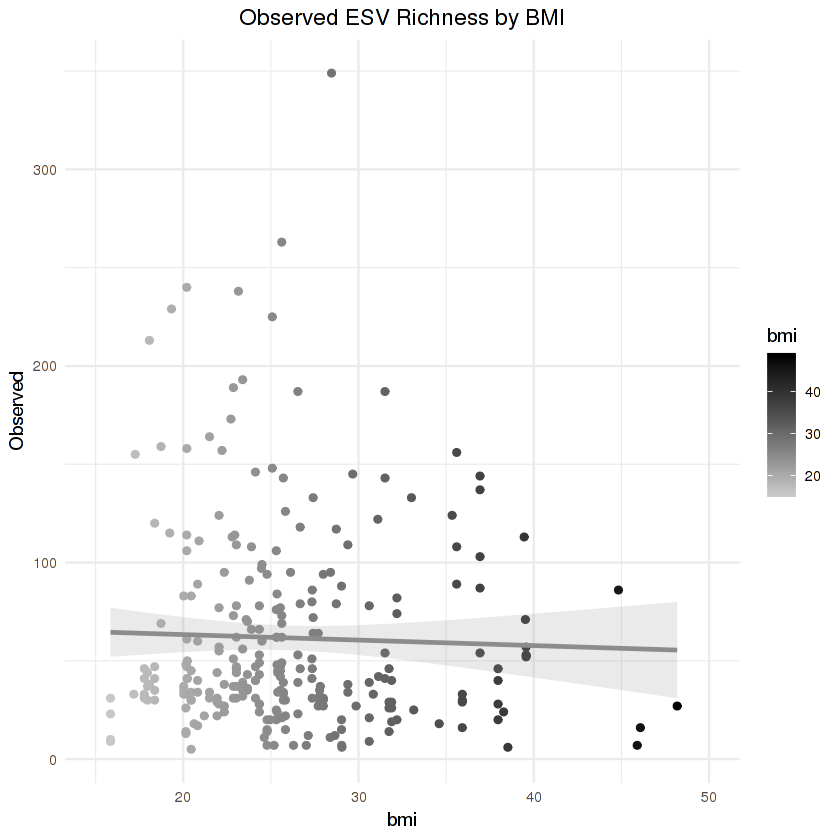

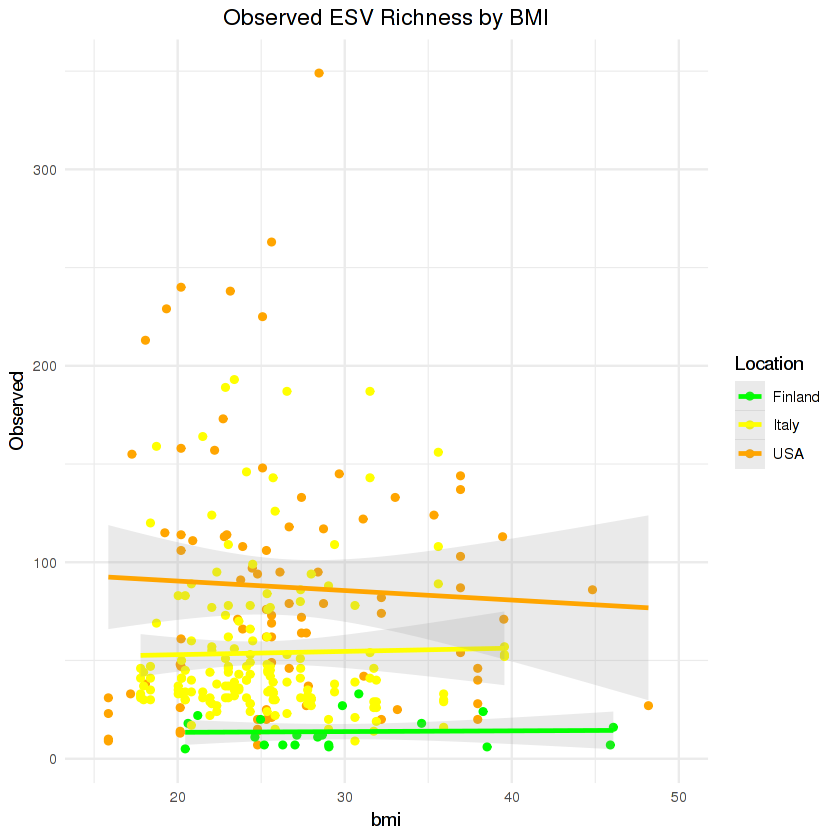

In [52]:
p3 = ggplot(dfobs, aes(x=bmi, y=Observed, colour = bmi)) + geom_point() + ggtitle("Observed ESV Richness by BMI")
p3 = p3 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") +
         theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) +
         scale_colour_gradient(low = "grey78", high = "black") +
         xlim(c(15,50))
p3

p4 = ggplot(dfobs, aes(x=bmi, y=Observed, colour = Location)) + geom_point() +  ggtitle("Observed ESV Richness by BMI")
p4 = p4 + geom_smooth(method = "lm", se=TRUE, alpha=.2) +
        theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) +
        scale_colour_manual(values = c("Green", "Yellow", "Orange")) +
        xlim(c(15,50))
p4

In [54]:
#SUMMARIZE REGRESSION COEFFICIENTS - Break down by sample type before running
fit <- lm(bmi ~ Observed, data = dfobs)
summary(fit)

In [81]:
# Record stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
cat("Observed Richness by PMI_hr Regression\n", file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)
capture.output(summary(fit), file = "/group/gilbert-lab/Lutz/Cadaver/All_cohorts/Report_data/stats.txt", append = TRUE)

In [68]:
dfobs.fin = dfobs[which(dfobs$Location=='Finland'),]
dfobs.ita = dfobs[which(dfobs$Location=='Italy'),]
dfobs.usa = dfobs[which(dfobs$Location=='USA'),]

In [71]:
head(dfobs.fin)

,SampleID,X,Observed,BarcodeSequence,LinkerPrimerSequence,RTL_run,Case_no,Sex,Age,Ethnicity,...,Organ,RTLID,Samplename,Cause_of_death,The_manner_of_death,Height_cm,Weight_kg,bmi,bmi_category,Description
87,4885.12Liver,4885.12Liver,7,AAAACAAA,GTGCCAGCMGCCGCGGTAA,4885,L549,M,56,C,...,Liver,12,12-MS515F,Phlebitis and thrombophlebitis,Natural,171,79,27.02,overweight,4885.12_Liver
88,4885.15Liver,4885.15Liver,6,AAAACAAC,GTGCCAGCMGCCGCGGTAA,4885,L558,M,64,C,...,Liver,15,15-MS515F,Hypertensive heart disease without congestive heart failure,Natural,183,129,38.52,obese,4885.15_Liver
89,4885.16Liver,4885.16Liver,22,AAAACAAG,GTGCCAGCMGCCGCGGTAA,4885,L568,M,55,C,...,Liver,16,16-MS515F,Accidental poisoning by and exposure to alcohol,Accident,171,62,21.20,normal,4885.16_Liver
90,4885.19Liver,4885.19Liver,7,AAAACAAT,GTGCCAGCMGCCGCGGTAA,4885,L572,M,75,C,...,Liver,19,19-MS515F,Atherosclerotic heart disease,Natural,176,78,25.18,overweight,4885.19_Liver
91,4885.26Liver,4885.26Liver,18,AAAACACA,GTGCCAGCMGCCGCGGTAA,4885,L584,M,68,C,...,Liver,26,26-MS515F,Duodenal ulcer,Natural,172,61,20.62,normal,4885.26_Liver
92,4885.34Liver,4885.34Liver,24,AAAACACC,GTGCCAGCMGCCGCGGTAA,4885,L603,M,59,C,...,Liver,34,34-MS515F,Alcoholic cardiomyopathy,Natural,160,98,38.28,obese,4885.34_Liver


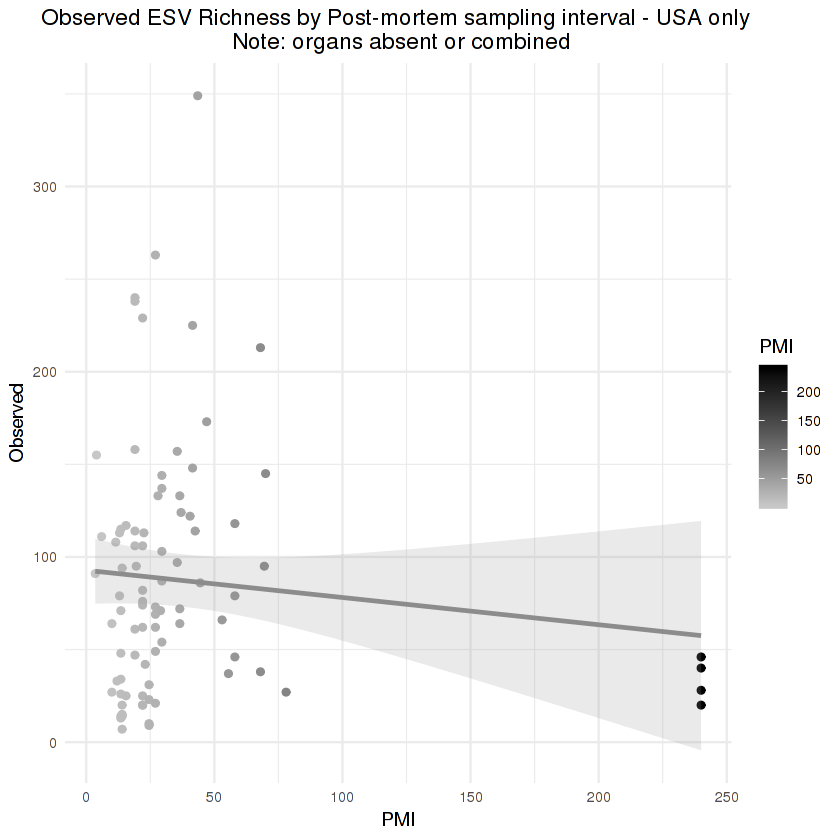

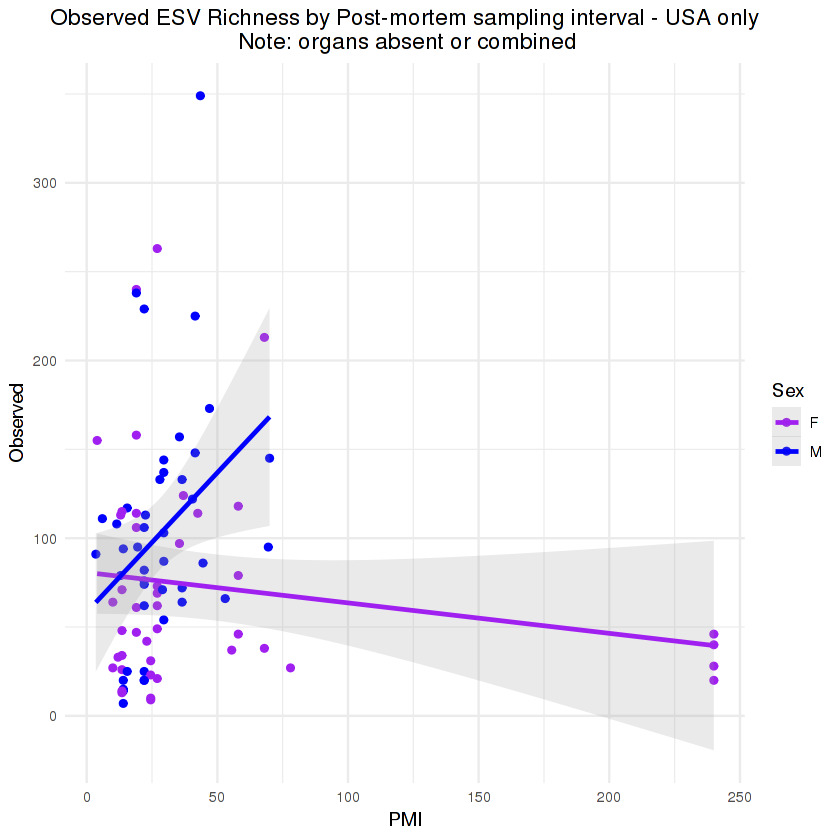

In [63]:
p5 = ggplot(dfobs.usa, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - USA only \n Note: organs absent or combined")
p5 = p5 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p5 = p5 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p5 = p5 + scale_colour_gradient(low = "grey78", high = "black")
p5

p6 = ggplot(dfobs.usa, aes(x=PMI, y=Observed, colour = Sex)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - USA only\n Note: organs absent or combined")
p6 = p6 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p6 = p6 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p6 = p6 + scale_colour_manual(values = c("Purple", "Blue"))
p6

In [57]:
fit <- lm(PMI ~ Observed, data = dfobs.usa)
summary(fit)


Call:
lm(formula = PMI ~ Observed, data = dfobs.usa)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.043 -22.129 -13.581   2.946 198.997 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 44.54053    8.56735   5.199 1.39e-06 ***
Observed    -0.07690    0.07847  -0.980     0.33    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47.77 on 84 degrees of freedom
Multiple R-squared:  0.01131,	Adjusted R-squared:  -0.0004651 
F-statistic: 0.9605 on 1 and 84 DF,  p-value: 0.3299


In [21]:
# Record stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("USA only - Observed Richness by PMI_hr Regression\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(summary(fit), file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

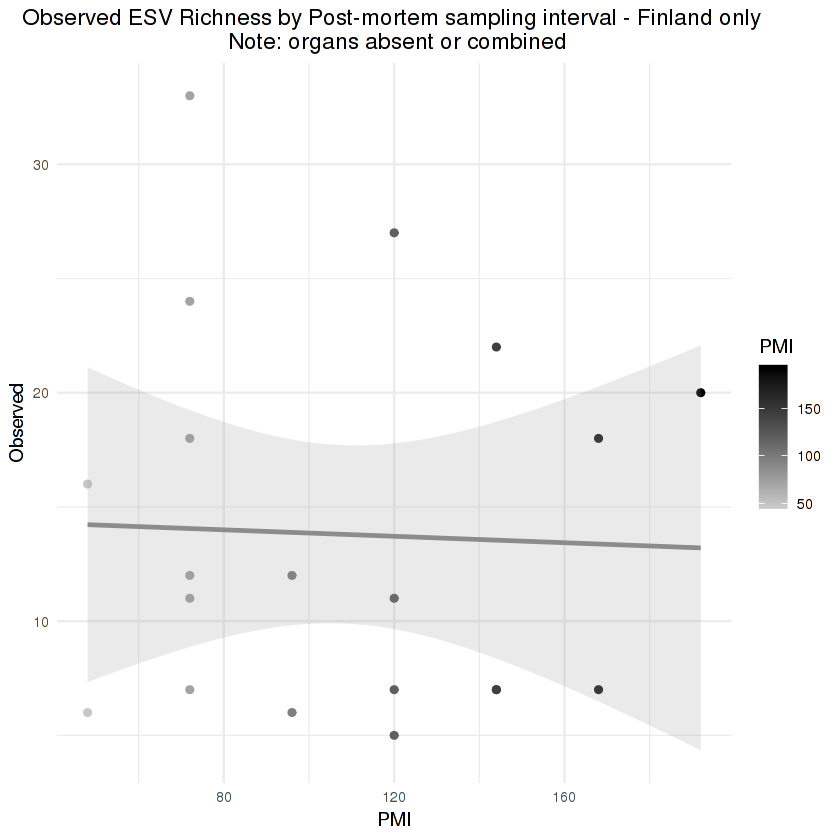

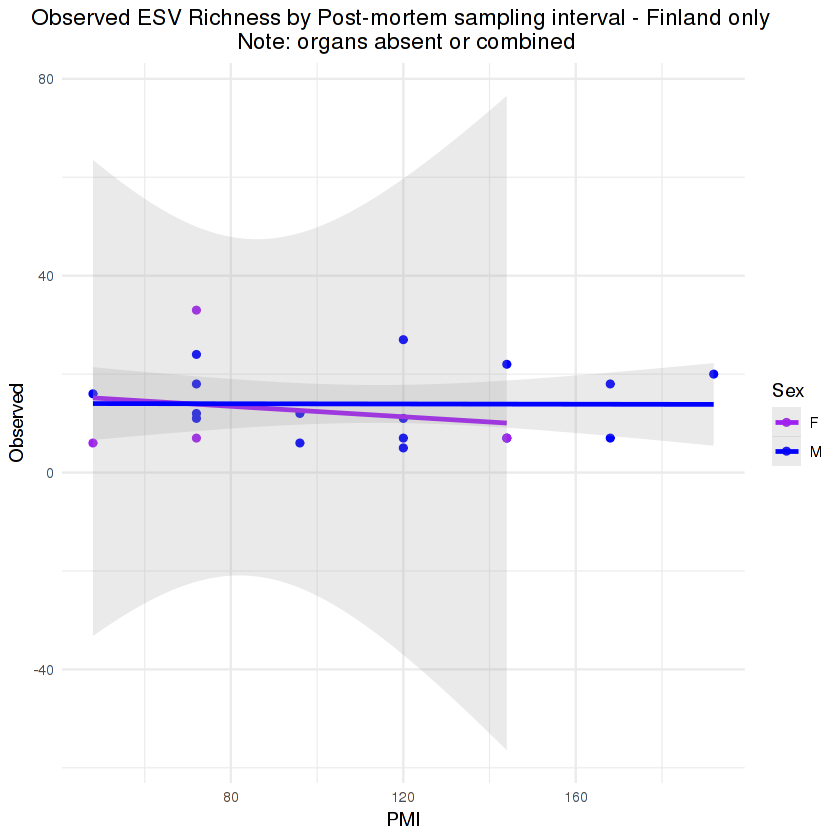

In [72]:
p7 = ggplot(dfobs.fin, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Finland only \n Note: organs absent or combined")
p7 = p7 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p7 = p7 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p7 = p7 + scale_colour_gradient(low = "grey78", high = "black")
p7

p8 = ggplot(dfobs.fin, aes(x=PMI, y=Observed, colour = Sex)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Finland only \n Note: organs absent or combined")
p8 = p8 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p8 = p8 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p8 = p8 + scale_colour_manual(values = c("Purple", "Blue"))
p8

In [22]:
fit <- lm(PMI ~ Observed, data = dfobs.fin)
summary(fit)


Call:
lm(formula = PMI ~ Observed, data = dfobs.fin)

Residuals:
   Min     1Q Median     3Q    Max 
-59.81 -34.42 -10.62  36.58  86.58 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 108.8128    19.0398   5.715 1.65e-05 ***
Observed     -0.1995     1.3077  -0.153     0.88    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 43.03 on 19 degrees of freedom
Multiple R-squared:  0.001224,	Adjusted R-squared:  -0.05134 
F-statistic: 0.02328 on 1 and 19 DF,  p-value: 0.8803


In [23]:
# Record stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("Finland only - Observed Richness by PMI_hr Regression\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(summary(fit), file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

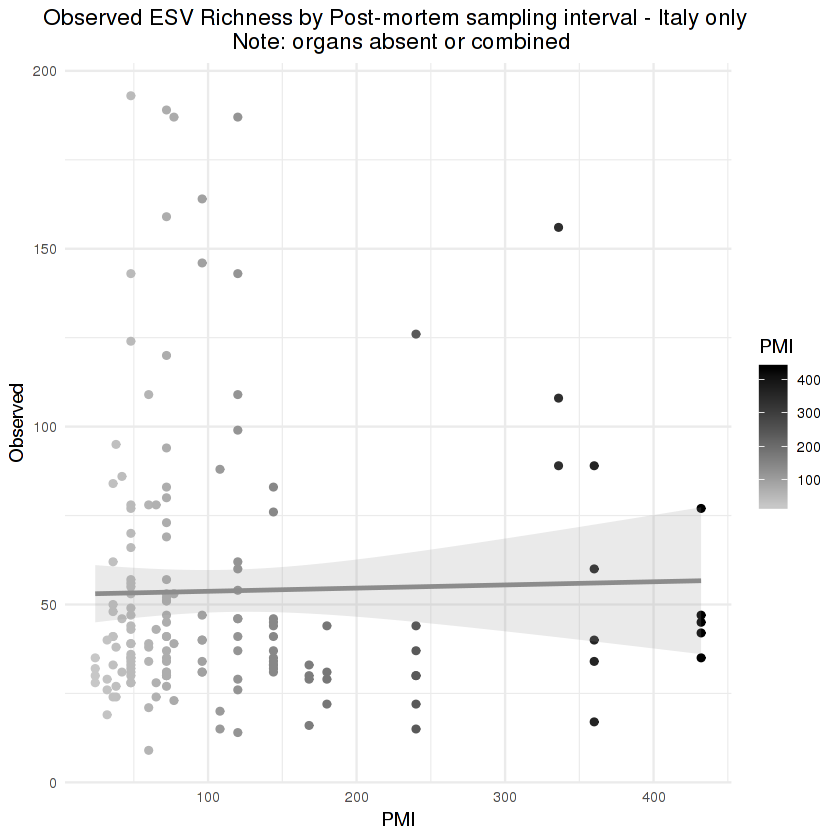

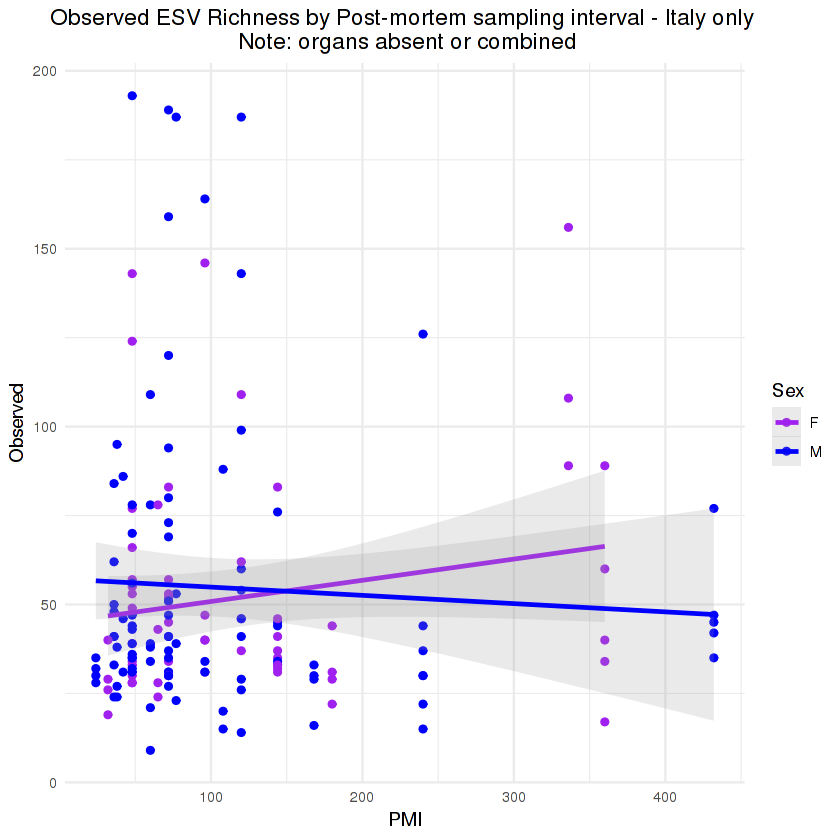

In [69]:
p9 = ggplot(dfobs.ita, aes(x=PMI, y=Observed, colour = PMI)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Italy only \n Note: organs absent or combined")
p9 = p9 + geom_smooth(method = "lm", se=TRUE, alpha=.2, colour = "grey55") #"loess"
p9 = p9 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p9 = p9 + scale_colour_gradient(low = "grey78", high = "black")
p9

p10 = ggplot(dfobs.ita, aes(x=PMI, y=Observed, colour = Sex)) + geom_point() + 
        ggtitle("Observed ESV Richness by Post-mortem sampling interval - Italy only \n Note: organs absent or combined")
p10 = p10 + geom_smooth(method = "lm", se=TRUE, alpha=.2)
p10 = p10 + theme_minimal() + theme(plot.title = element_text(hjust = 0.5)) 
p10 = p10 + scale_colour_manual(values = c("Purple", "Blue"))
p10

## HAVE NOT RUN FOLLOWING BDIV ANALYSES ON ALL COHORTS COMBINED YET

### START HERE:

### Betadiversity

In [88]:
cadaver.df = data.frame(sample_data(cadaver))

In [90]:
# WEIGHTED UNIFRAC
cadaver.dist.wunif = distance(cadaver, method = "wunifrac", type = "samples")
cadaver.wunif.adtest = adonis2(cadaver.dist.wunif ~ Sex + Age + Ethnicity + The.manner.of.death + PMI + bmi, strata = Locality, by = "margin", data=cadaver.df)
cadaver.wunif.adtest

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGGAGGGGGCTAGCGTTATTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGCTTTGTAAGTTAGAGGTGAAAGCCCGGAGCTCAACTCCGGAACTGCCTTTAAGACTGCATCGCTTGAATCCGGGAGAGGTGAGTGGAATTCCGAG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.18464028,0.02564665,2.0327953,0.049
Age,1,0.18039278,0.02505667,1.9860325,0.061
Ethnicity,2,0.17622320,0.02447751,0.9700637,0.458
The.manner.of.death,3,0.51340859,0.07131278,1.8841222,0.014
PMI,1,0.23824966,0.03309303,2.6230072,0.017
bmi,1,0.08480829,0.01177992,0.9336960,0.514
Residual,58,5.26818237,0.73175386,NA,NA
Total,67,7.19939130,1.00000000,NA,NA


In [91]:
# UNWEIGHTED UNIFRAC
cadaver.dist.unif = distance(cadaver, method = "unifrac", type = "samples")
cadaver.unif.adtest = adonis2(cadaver.dist.unif ~ Sex + Age + Ethnicity + The.manner.of.death + PMI + bmi, strata = Locality, by = "margin", data=cadaver.df)
cadaver.unif.adtest

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGGGGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGCGCGTAGGCGGGACGTCAAGTCAGCGGTAAAAGACTGCAGCTAAACTGTAGCACGCCGTTGAAACTGGCGCCCTGGAGACGAGACGAGGGAGGCGGAACAAGTGAA -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.2245641,0.01311843,1.0387621,0.334
Age,1,0.4113528,0.02403012,1.9027869,0.039
Ethnicity,2,0.5085661,0.02970907,1.1762324,0.213
The.manner.of.death,3,0.8682916,0.05072326,1.3388134,0.123
PMI,1,1.0829688,0.06326412,5.0094684,0.001
bmi,1,0.2082932,0.01216793,0.9634981,0.488
Residual,58,12.5386941,0.73247676,NA,NA
Total,67,17.1182142,1.00000000,NA,NA


In [92]:
# BRAY-CURTIS
cadaver.dist.bc = distance(cadaver, method = "bray", type = "samples")
cadaver.bc.adtest = adonis2(cadaver.dist.bc ~ Sex + Age + Ethnicity + The.manner.of.death + PMI + bmi, strata = Locality, by = "margin", data=cadaver.df)
cadaver.bc.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
Sex,1,0.6786432,0.02242474,1.6009085,0.063
Age,1,0.5526084,0.01826011,1.3035944,0.153
Ethnicity,2,0.8010969,0.02647103,0.9448873,0.559
The.manner.of.death,3,1.7562704,0.05803329,1.3810045,0.024
PMI,1,0.5725741,0.01891984,1.3506931,0.123
bmi,1,0.4365889,0.01442642,1.0299063,0.431
Residual,58,24.5868562,0.81243543,NA,NA
Total,67,30.2631512,1.00000000,NA,NA


In [93]:
# Record stats
# Wunif adonis2 stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.wunif.adtest - with MoD\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.wunif.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
# Unif adonis2 stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.unif.adtest - with MoD\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.unif.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
#Bray-Curtis adonis2 stats
cat("\n\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
cat("cadaver.bc.adtest - with MoD\n", file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)
capture.output(cadaver.bc.adtest, file = "/group/gilbert-lab/Lutz/Cadaver/Report_data/3813_4522_4885/stats.txt", append = TRUE)

In [94]:
cadaver.wunif.log = ordinate(cadaver, method = "PCoA", distance = "wunifrac")
cadaver.wunif.evals = cadaver.wunif.log$values$Eigenvalues

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGAAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGAAGTGAAAGCCCCGGGCTCAACCTGGGAATTGCTTTCAAAACTGACAGGCTAGAGTACGGTAGAGGGTAGTGGAATTTCCTG -- in the phylogenetic tree in the data you provided.”

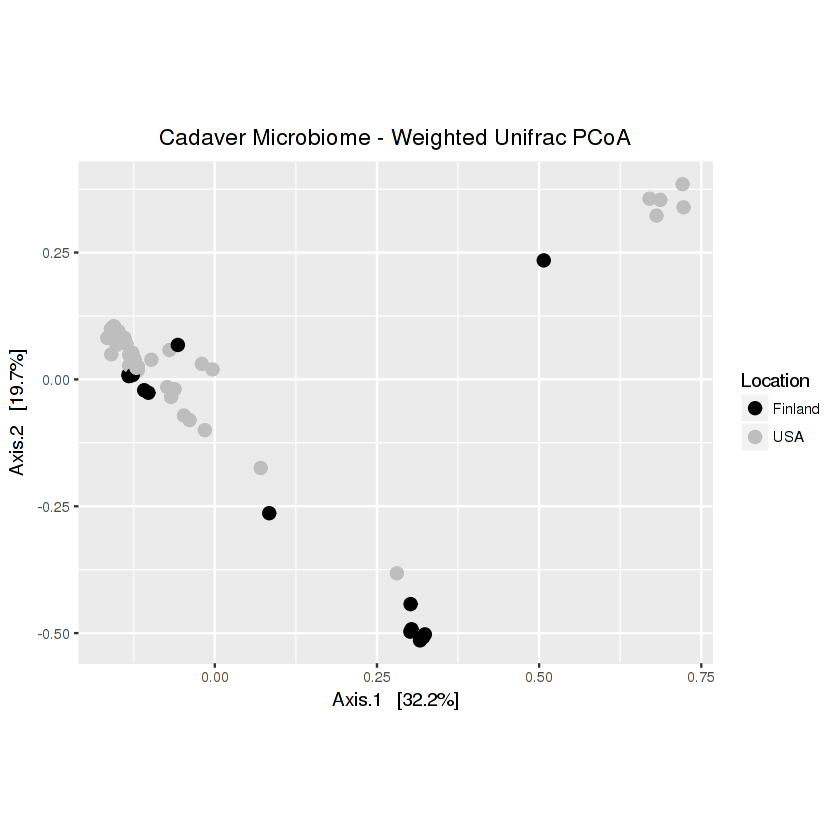

In [95]:
p = plot_ordination(cadaver, cadaver.wunif.log, color = "Location") + 
    ggtitle("Cadaver Microbiome - Weighted Unifrac PCoA") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.wunif.evals[2] / cadaver.wunif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
p = p + scale_colour_manual(values = c("Black", "Gray"))
#p = p + scale_colour_brewer(palette="Spectral")
p                            

In [96]:
cadaver.unif.log = ordinate(cadaver, method = "PCoA", distance = "unifrac")
cadaver.unif.evals = cadaver.unif.log$values$Eigenvalues

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTATGTCACAAGCGTTATCCGGATTTATTGGGCGTAAAGCGCGTCTAGGTGGTTATGTAAGTCTGATGTGAAAATGCGGGGCTCAACTCTGTATTGCGTTGGAAACTGCATGACTAGAGTACTGGAGAGGTAAGCGGAACTACAAGT -- in the phylogenetic tree in the data you provided.”

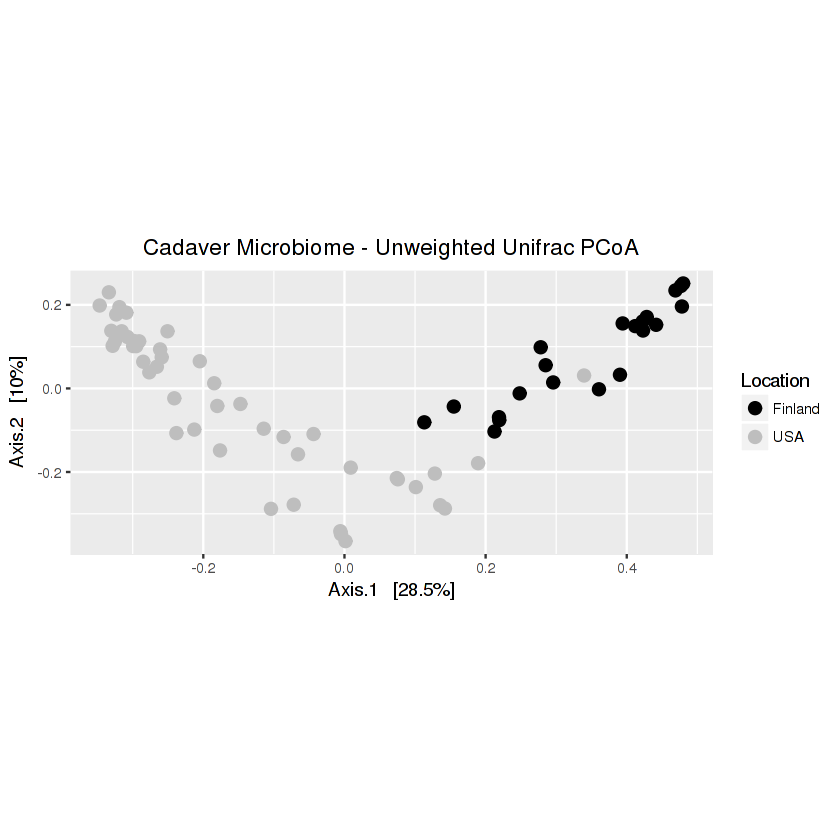

In [97]:
p = plot_ordination(cadaver, cadaver.unif.log, color = "Location") + 
    ggtitle("Cadaver Microbiome - Unweighted Unifrac PCoA") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.unif.evals[2] / cadaver.unif.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
p = p + scale_colour_manual(values = c("Black", "Gray"))
#p = p + scale_colour_brewer(palette="Spectral")
p    

In [98]:
cadaver.bc.log = ordinate(cadaver, method = "PCoA", distance = "bray")
cadaver.bc.evals = cadaver.bc.log$values$Eigenvalues

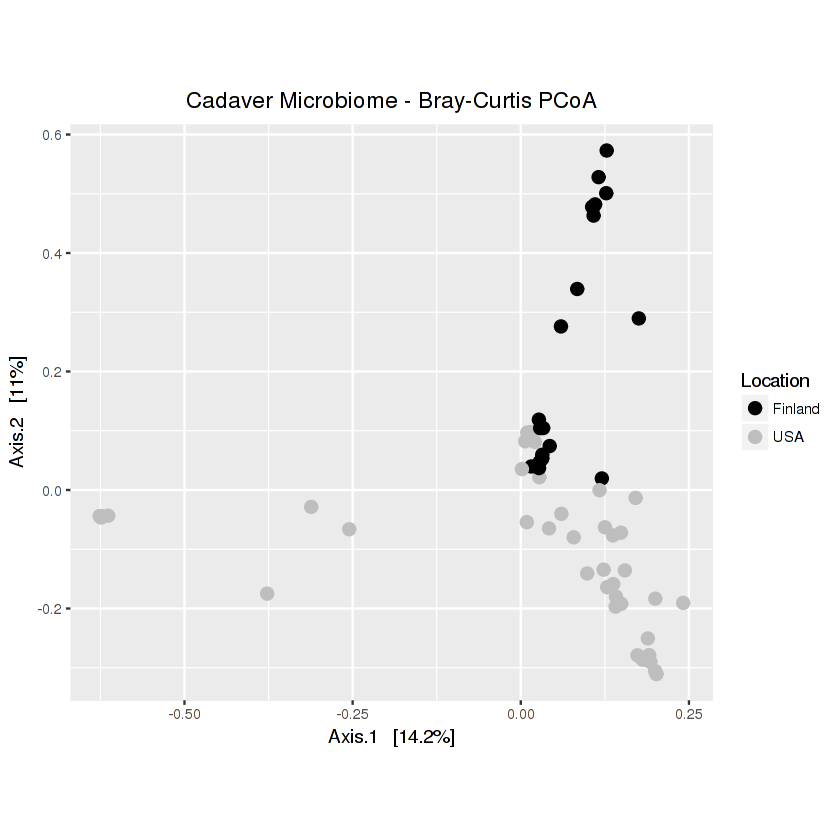

In [99]:
p = plot_ordination(cadaver, cadaver.bc.log, color = "Location") + 
    ggtitle("Cadaver Microbiome - Bray-Curtis PCoA") + 
    geom_point(size=3) + 
    coord_fixed(sqrt(cadaver.bc.evals[2] / cadaver.bc.evals[1])) +
    theme(plot.title = element_text(hjust=0.5))
p = p + scale_colour_manual(values = c("Black", "Gray"))
#p = p + scale_colour_brewer(palette="Spectral")
p    

#### Betadispersion

In [100]:
#Weighted Unifrac

beta.disp.cadaver.wuf = betadisper(cadaver.dist.wunif,group = sample_data(cadaver)$The.manner.of.death)
beta.disp.cadaver.wuf = beta.disp.cadaver.wuf$distances
beta.disp.cadaver.wuf = data.frame(d = beta.disp.cadaver.wuf, SampleID = names(beta.disp.cadaver.wuf))
beta.disp.cadaver.wuf2 = left_join(beta.disp.cadaver.wuf, sample_tab, by="SampleID")

Warning message:
“Column `SampleID` joining factors with different levels, coercing to character vector”

In [101]:
cadaver.wunif_summary = summary(beta.disp.cadaver.wuf2$d)
cadaver.wunif_summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1384  0.2365  0.3015  0.2972  0.3424  0.5310 

In [102]:
#Sort by ascending mean
avg_obs <- aggregate(d ~ The.manner.of.death, data = beta.disp.cadaver.wuf2, mean)
beta.disp.cadaver.wuf2$Manner_of_death <-factor(beta.disp.cadaver.wuf2$The.manner.of.death, levels=avg_obs[order(avg_obs$d), "The.manner.of.death"])

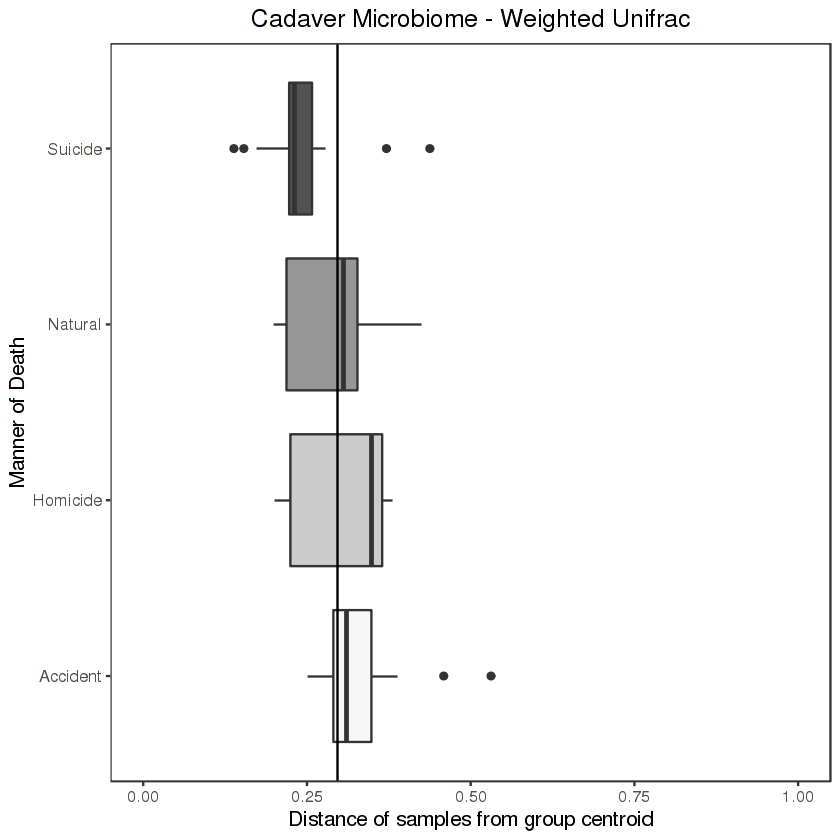

In [103]:
p = ggplot(beta.disp.cadaver.wuf2, aes(x = as.factor(The.manner.of.death), y = d, fill = as.factor(The.manner.of.death))) + ggtitle("Cadaver Microbiome - Weighted Unifrac")

p = p + geom_boxplot() + 
        ylab("Distance of samples from group centroid") + 
        xlab("Manner of Death") + 
        coord_flip(ylim = c(0,1))

p = p + scale_fill_brewer(palette="Greys")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           plot.title = element_text(hjust = 0.5),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#Mean taken from "cadaver.wunif_summary"
p = p + geom_hline(yintercept = 0.2972)

p

In [104]:
#Unweighted Unifrac

beta.disp.cadaver.uf = betadisper(cadaver.dist.unif,group = sample_data(cadaver)$The.manner.of.death)
beta.disp.cadaver.uf = beta.disp.cadaver.uf$distances
beta.disp.cadaver.uf = data.frame(d = beta.disp.cadaver.uf, SampleID = names(beta.disp.cadaver.uf))
beta.disp.cadaver.uf2 = left_join(beta.disp.cadaver.uf, sample_tab, by="SampleID")

cadaver.unif_summary = summary(beta.disp.cadaver.uf2$d)
cadaver.unif_summary

Warning message:
“Column `SampleID` joining factors with different levels, coercing to character vector”

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3069  0.4263  0.4606  0.4709  0.5033  0.7553 

In [105]:
#Sort by ascending mean
avg_obs <- aggregate(d ~ The.manner.of.death, data = beta.disp.cadaver.uf2, mean)
beta.disp.cadaver.uf2$The.manner.of.death <-factor(beta.disp.cadaver.uf2$The.manner.of.death, levels=avg_obs[order(avg_obs$d), "The.manner.of.death"])

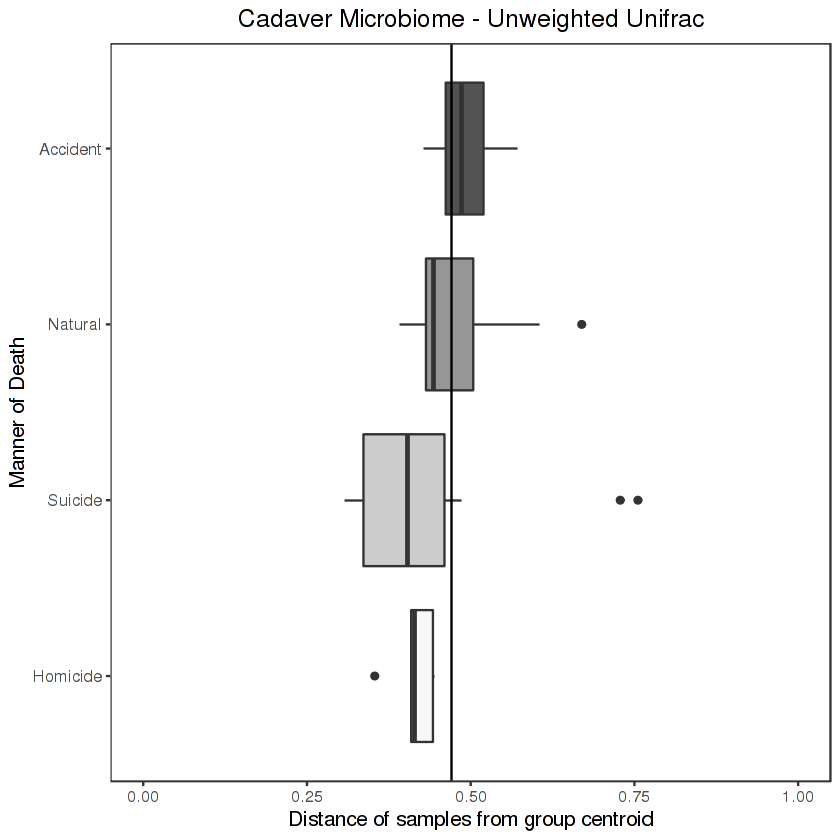

In [106]:
p = ggplot(beta.disp.cadaver.uf2, aes(x = as.factor(The.manner.of.death), y = d, fill = as.factor(The.manner.of.death))) + ggtitle("Cadaver Microbiome - Unweighted Unifrac")

p = p + geom_boxplot() + 
        ylab("Distance of samples from group centroid") + 
        xlab("Manner of Death") + 
        coord_flip(ylim = c(0,1))

p = p + scale_fill_brewer(palette="Greys")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           plot.title = element_text(hjust = 0.5),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#Mean taken from "cadaver.unif_summary"
p = p + geom_hline(yintercept = 0.4709)

p

In [107]:
#Bray-Curtis

beta.disp.cadaver.bc = betadisper(cadaver.dist.bc,group = sample_data(cadaver)$The.manner.of.death)
beta.disp.cadaver.bc = beta.disp.cadaver.bc$distances
beta.disp.cadaver.bc = data.frame(d = beta.disp.cadaver.bc, SampleID = names(beta.disp.cadaver.bc))
beta.disp.cadaver.bc2 = left_join(beta.disp.cadaver.bc, sample_tab, by="SampleID")

cadaver.bc_summary = summary(beta.disp.cadaver.bc2$d)
cadaver.bc_summary

Warning message:
“Column `SampleID` joining factors with different levels, coercing to character vector”

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.4912  0.5995  0.6500  0.6381  0.6860  0.7633 

In [109]:
#Sort by ascending mean
avg_obs <- aggregate(d ~ The.manner.of.death, data = beta.disp.cadaver.bc2, mean)
beta.disp.cadaver.bc2$The.manner.of.death <-factor(beta.disp.cadaver.bc2$The.manner.of.death, levels=avg_obs[order(avg_obs$d), "The.manner.of.death"])

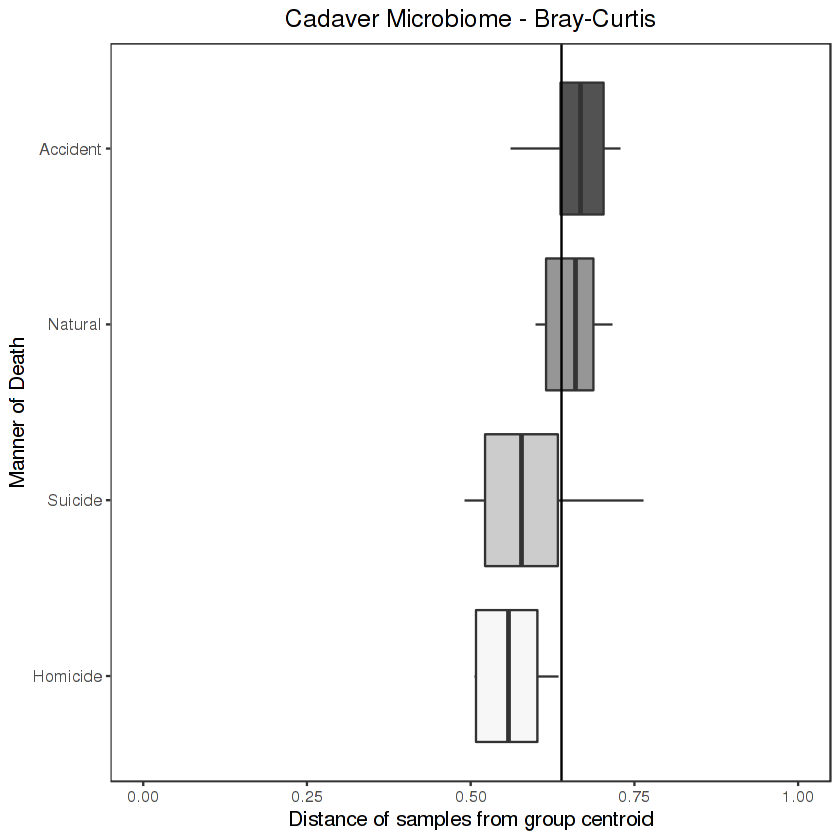

In [111]:
p = ggplot(beta.disp.cadaver.bc2, aes(x = as.factor(The.manner.of.death), y = d, fill = as.factor(The.manner.of.death))) + ggtitle("Cadaver Microbiome - Bray-Curtis")

p = p + geom_boxplot() + 
        ylab("Distance of samples from group centroid") + 
        xlab("Manner of Death") + 
        coord_flip(ylim = c(0,1))

p = p + scale_fill_brewer(palette="Greys")

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           plot.title = element_text(hjust = 0.5),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none")
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#Mean taken from "cadaver.unif_summary"
p = p + geom_hline(yintercept = 0.6381)

p

### Rank Abundance

In [5]:
cadaver.mdf = psmelt(cadaver)

In [6]:
write.csv(cadaver.mdf, "/group/gilbert-lab/Lutz/Cadaver/phyloseq_files_30June2018/cadaver.mdf.csv")

In [43]:
colnames(cadaver.mdf)

[1] "X"                    "OTU"                  "Sample"              
 [4] "Abundance"            "X.SampleID"           "BarcodeSequence"     
 [7] "LinkerPrimerSequence" "RTL_run"              "Case_no"             
[10] "Sex"                  "Age"                  "Ethnicity"           
[13] "Order"                "Location"             "PMI"                 
[16] "Organ"                "RTLID"                "Samplename"          
[19] "Cause.of.death"       "The.manner.of.death"  "Height.cm"           
[22] "Weight.kg"            "bmi"                  "bmi_category"        
[25] "Description"          "Rank1"                "Rank2"               
[28] "Rank3"                "Rank4"                "Rank5"               
[31] "Rank6"                "Rank7"                "TaxID"

In [25]:
#New column "TaxID" to identify highest level of taxonomic identification
cadaver.mdf = read.csv("/group/gilbert-lab/Lutz/Cadaver/phyloseq_files_30June2018/cadaver.mdf.csv")


In [26]:
#Subset by Locality

cadaver.usa.mdf = cadaver.mdf[which(cadaver.mdf$Location=='USA'),]
cadaver.fin.mdf = cadaver.mdf[which(cadaver.mdf$Location=='Finland'),]

In [27]:
colnames(cadaver.fin.mdf)

[1] "X"                    "OTU"                  "Sample"              
 [4] "Abundance"            "X.SampleID"           "BarcodeSequence"     
 [7] "LinkerPrimerSequence" "RTL_run"              "Case_no"             
[10] "Sex"                  "Age"                  "Ethnicity"           
[13] "Order"                "Location"             "PMI"                 
[16] "PMI_days"             "Organ"                "RTLID"               
[19] "Samplename"           "Cause.of.death"       "The.manner.of.death" 
[22] "Height.cm"            "Weight.kg"            "bmi"                 
[25] "bmi_category"         "Description"          "Rank1"               
[28] "Rank2"                "Rank3"                "Rank4"               
[31] "Rank5"                "Rank6"                "Rank7"               
[34] "TaxID"

#### Plot top taxa

In [34]:
N = 15

topN = cadaver.usa.mdf %>%
    group_by(TaxID) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(TaxID) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("TaxID")

mdf.other = cadaver.usa.mdf %>%
    mutate(TaxID.other = ifelse(TaxID %in% topN, as.character(TaxID), "Other")) %>%
    group_by(Sample, TaxID.other, PMI_days) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(TaxID.other, PMI_days) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((TaxID.other))

Selecting by m


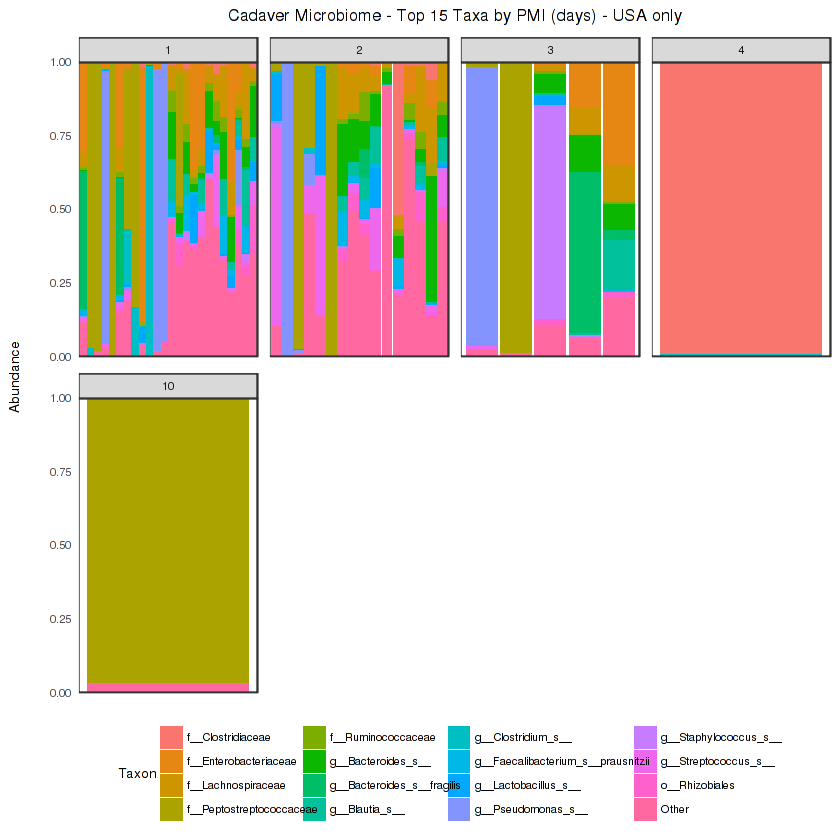

In [35]:
#mdf.other$Location <- factor(mdf.other$Location)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = TaxID.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) #+ 
    #scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Taxon", ncol = 5, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=8, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              legend.key.width = unit(0.5, "mm"),
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))
               
p = p + ggtitle("Cadaver Microbiome - Top 15 Taxa by PMI (days) - USA only")

p = p + facet_wrap(~PMI_days, scales = "free_x", ncol = 4)

#p = p + facet_grid(The.manner.of.death ~ Sex, scales = "free_x")

p

#### Plot top 10 most abundant families

In [33]:
N = 10

topN = cadaver.mdf %>%
    group_by(Rank6_7) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank6_7) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank6_7")

mdf.other = cadaver.mdf %>%
    mutate(Rank6_7.other = ifelse(Rank6_7 %in% topN, as.character(Rank6_7), "Other")) %>%
    group_by(Sample, Rank6_7.other, Location, bmi_category) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank6_7.other, Location, bmi_category) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank6_7.other))

Selecting by m


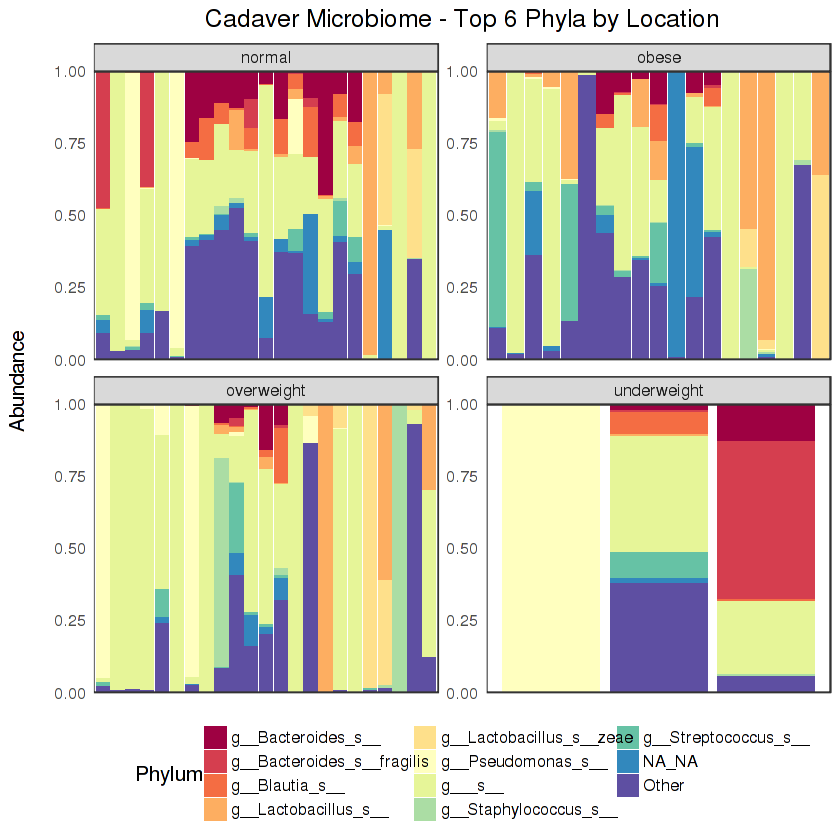

In [41]:
mdf.other$Location <- factor(mdf.other$Location)

p = ggplot(mdf.other, aes(x=factor(Sample), y = Abundance, fill = Rank6_7.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Phylum", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=12, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 6 Phyla by Location")

p = p + facet_wrap(~bmi_category, shrink = TRUE, scales = "free")

p

#### Top 10 Orders by Manner of Death

In [143]:
N = 10

topN = cadaver.mdf %>%
    group_by(Rank4) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank4) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank4")

mdf.other = cadaver.mdf %>%
    mutate(Rank4.other = ifelse(Rank4 %in% topN, as.character(Rank4), "Other")) %>%
    group_by(Sample, Rank4.other, The.manner.of.death) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank4.other, The.manner.of.death) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank4.other))

Selecting by m


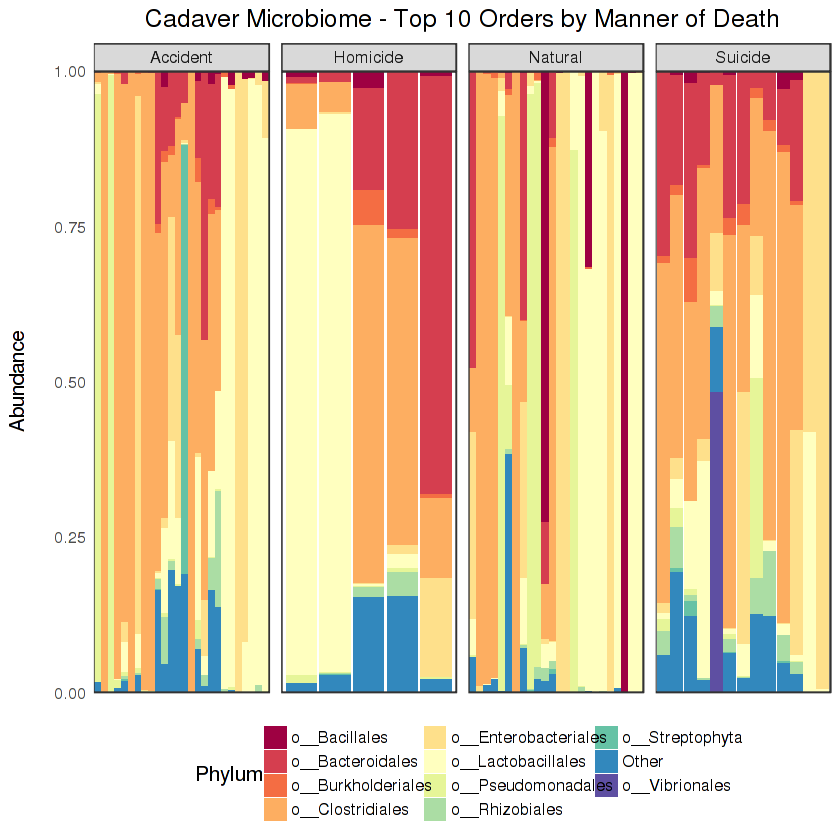

In [145]:
mdf.other$The.manner.of.death <- factor(mdf.other$The.manner.of.death)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = Rank4.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Phylum", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=12, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 10 Orders by Manner of Death")

p = p + facet_wrap(~The.manner.of.death, shrink = TRUE, scales = "free_x", ncol=4)

p

#### Top 10 Orders by Location

In [146]:
N = 10

topN = cadaver.mdf %>%
    group_by(Rank4) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank4) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank4")

mdf.other = cadaver.mdf %>%
    mutate(Rank4.other = ifelse(Rank4 %in% topN, as.character(Rank4), "Other")) %>%
    group_by(Sample, Rank4.other, Location) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdf.summary = mdf.other %>%
    group_by(Rank4.other, Location) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank4.other))

Selecting by m


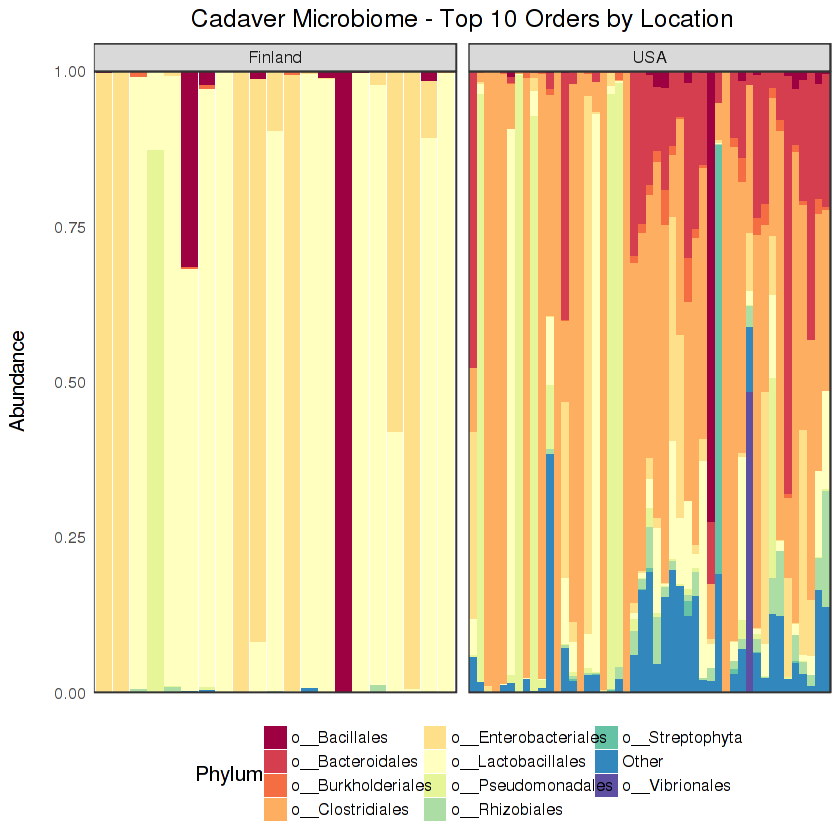

In [147]:
mdf.other$Location <- factor(mdf.other$Location)

p = ggplot(mdf.other, aes(x=Sample, y = Abundance, fill = Rank4.other)) + 
    geom_bar(stat="identity") + 
    scale_y_continuous(expand = c(0,0)) + 
    scale_fill_brewer(palette = "Spectral", na.value= "#0E024C", direction=1) 

p = p + guides(fill = guide_legend(title = "Phylum", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              plot.title = element_text(hjust = 0.5),
              text=element_text(size=12, color="black",family="Times New Roman"),
              panel.grid.minor = element_blank(),
              axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              legend.key.size = unit(1, "mm"),
              legend.spacing.x = unit(3,"in"),
              legend.position = "bottom",
              axis.title.x=element_blank(),
              panel.spacing = unit(.5, "lines"))

p = p + ggtitle("Cadaver Microbiome - Top 10 Orders by Location")

p = p + facet_wrap(~Location, shrink = TRUE, scales = "free_x", ncol=4)

p